<h1>Wstęp</h1>

Celem projektu jest wytrenowanie dwóch modeli: klasycznej sieci splotowej (CNN) oraz jej wariantu – sieci resztkowej (ResNet) – na podstawie zbioru danych EMNIST. Następnie zostanie stworzona [aplikacja](app.py), która umożliwi użytkownikowi samodzielne sprawdzenie predykcji wytrenowanego modelu.

<h1>Przygotowanie danych</h1>

<h2>Import bibliotek</h2>

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

<h2>Import danych</h2>

Wykorzystamy zbiór EMNIST balanced (131600 znaków, 47 unikalnych klas) przekonwertowany i podzielony już na pliki formatu .csv </br>
Poniższy kod pobiera dane treningowe, testowe i mapujące z kaggle (https://www.kaggle.com/datasets/crawford/emnist).

In [77]:
import os
import zipfile

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

os.system(f"kaggle datasets download -d crawford/emnist -p ./data")

with zipfile.ZipFile("./data/emnist.zip", 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if "balanced" in file_name and (file_name.endswith(".csv") or file_name.endswith(".txt")):
            zip_ref.extract(file_name, "./data")
            print(f"Extracted: {file_name}")
print("Dataset extracted.")


Extracted: emnist-balanced-mapping.txt
Extracted: emnist-balanced-test.csv
Extracted: emnist-balanced-train.csv
Dataset extracted.


Baza EMNIST balanced, pobrana w plikach, jest już podzielona: 112800 elementów w danych treningowych (86%) oraz 18800 w testowych (14%). Choć standardowy, zalecany (zasada Pareta) podział to 80:20, w tym przypadku liczba 18800 elementów testowych jest wystarczająca, biorąc pod uwagę rozmiar zbioru.

In [78]:
train = pd.read_csv('data/emnist-balanced-train.csv', header=None)
test = pd.read_csv('data/emnist-balanced-test.csv', header=None)

train.shape, test.shape

((112800, 785), (18800, 785))

In [79]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112800 entries, 0 to 112799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 675.6 MB


Nie ma brakujących wartości w obu zbiorach.

In [81]:
nan_values = train.columns[train.isna().any()].tolist() + test.columns[test.isna().any()].tolist()
nan_values

[]

Plik z danymi treningowymi zawiera 112800 wierszy i 785 kolumn. Pierwsza kolumna to etykieta (numer od 0 do 46), a pozostałe 784 kolumny przedstawiają piksele obrazu 28x28. Taki sam układ występuje w pliku z danymi testowymi. Etykiety odpowiadają cyfrom oraz dużym i małym literom alfabetu angielskiego. Mapowanie etykiet znajduje się w pliku emnist-balanced-mapping.txt.

In [82]:
mapping = pd.read_csv('data/emnist-balanced-mapping.txt', delimiter=' ', header=None)
mapping_dict = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

print(f"Mapping size: {len(mapping)}")
print(dict(list(mapping_dict.items())))

Mapping size: 47
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


Dystrybucja etykiet (klas) w danych treningowych i testowych jest zrównoważona – każda etykieta występuje tyle samo razy. Dla danych treningowych: 47\*2400=112800, a testowych: 47\*400=18800. Można z tego wysnuć wniosek, iż gotowy podział zbioru na dane testowe i treningowe jest bardzo dobry.

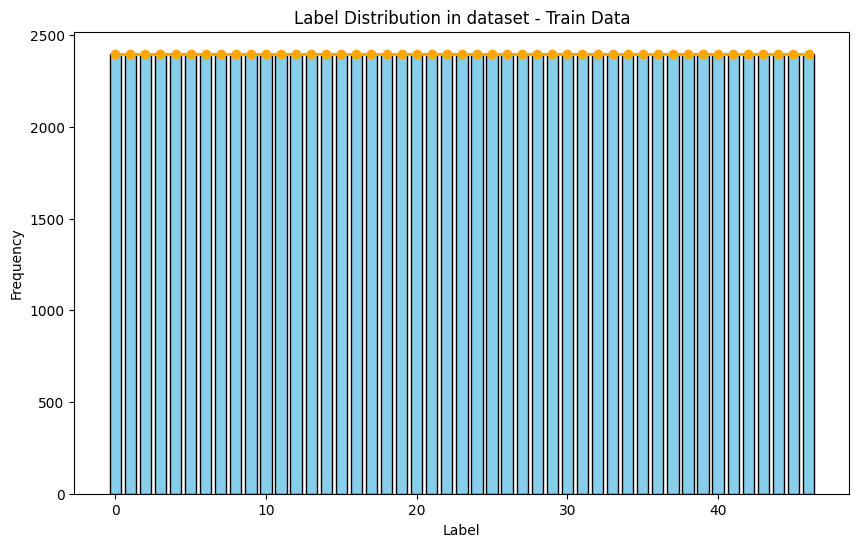

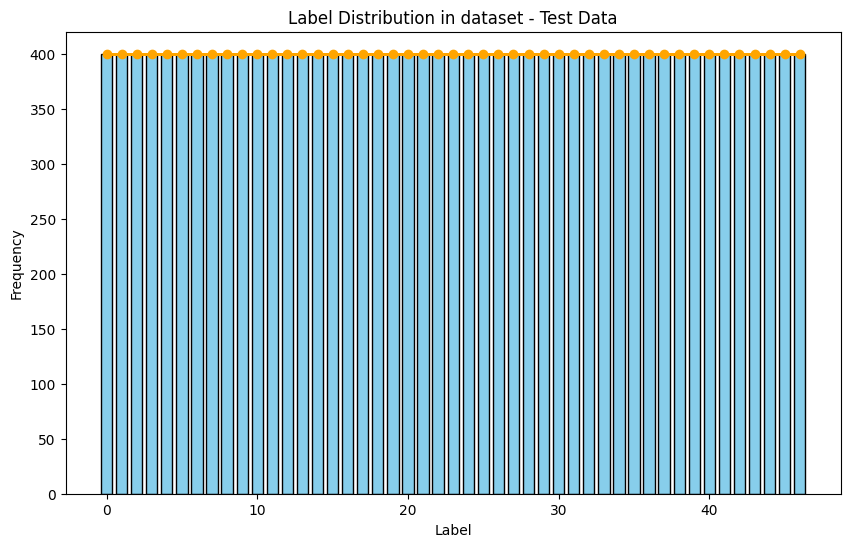

In [83]:
import matplotlib.pyplot as plt

for dataset_name, t_ in [("Train Data", train[0].value_counts()), ("Test Data", test[0].value_counts())]:
    t__classes_x = t_.index
    t__classes_y = t_.values

    plt.figure(figsize=(10, 6))
    
    plt.bar(t__classes_x, t__classes_y, width=0.75, color='skyblue', edgecolor='black', label='Frequency')
    plt.plot(t__classes_x, t__classes_y, color='orange', marker='o', linestyle='-', linewidth=2, label='Trend')

    plt.title(f'Label Distribution in dataset - {dataset_name}')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    
    plt.show()


Teraz wyświetlimy przykładowe dane ze zbioru treningowego.

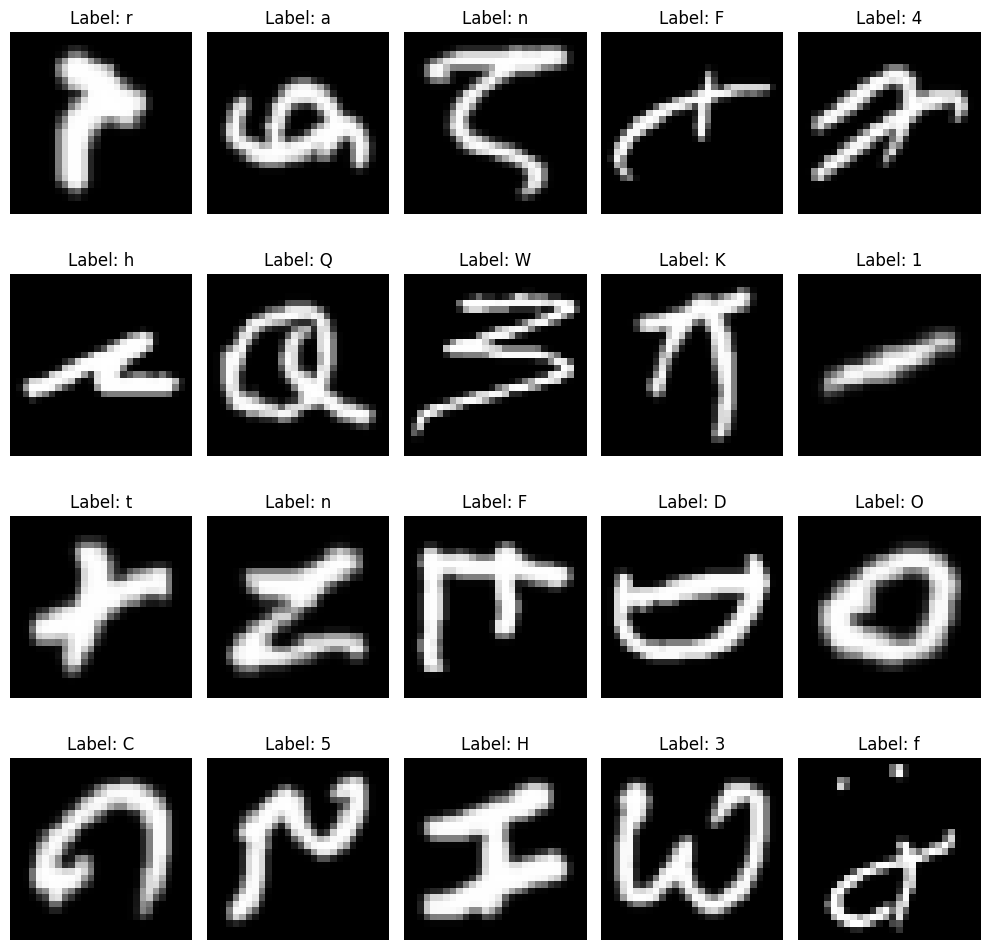

In [84]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    example = train.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Dane w zbiorze EMNIST są domyślnie odwrócone, więc należy je obrócić wokół osi okośnej.

In [85]:
for i in range(train.shape[0]):
    pixels = train.iloc[i,1:]
    
    image = pixels.values.reshape(28,28, 1).T
    pixels = image.flatten()
    
    train.iloc[i,1:] = pixels

for i in range(test.shape[0]):
    pixels = test.iloc[i,1:]
    
    image = pixels.values.reshape(28,28, 1).T
    pixels = image.flatten()
    
    test.iloc[i,1:] = pixels

I jeszcze raz wyświetlimy (w poprawnym już formacie) dane.

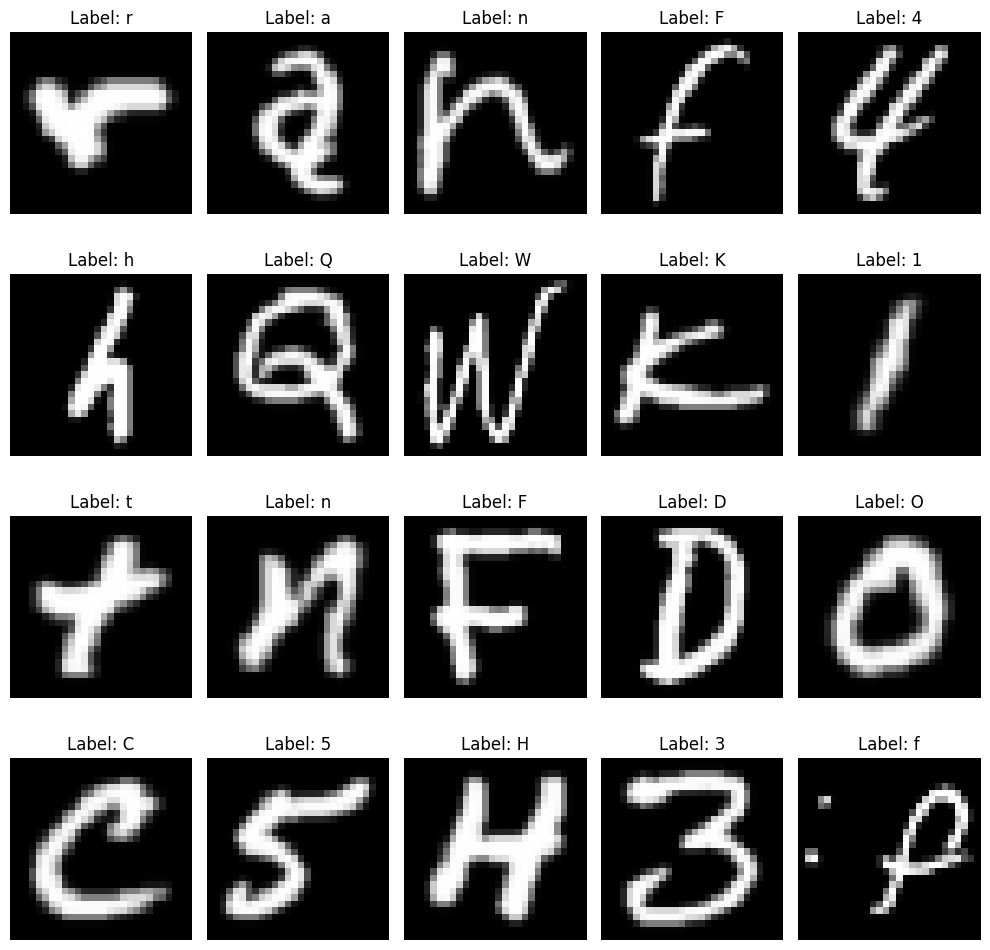

In [86]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    example = train.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Pobieramy napisane wcześniej [modele](models.py), by na nich wytrenować zbiór EMNIST.

In [87]:
from models import SimpleCNN
from models import ResidualBlock, ResNet

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype('float32')
        self.y = y.astype('int64')
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(10),  # Random rotations within ±10°
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small random translations
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3, 3))], p=0.3),  # Light Gaussian blur
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].reshape(28, 28)
        X = self.transform(X)
        y = self.y[idx]
        return X, y


In [89]:
train_X = train.iloc[:, 1:].reset_index(drop=True).values / 255.0
train_y = train.iloc[:, 0].reset_index(drop=True).values

train_dataset = EMNISTDataset(train_X, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [90]:
test_X = test.iloc[:, 1:].reset_index(drop=True).values / 255.0
test_y = test.iloc[:, 0].reset_index(drop=True).values

test_dataset = EMNISTDataset(test_X, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)

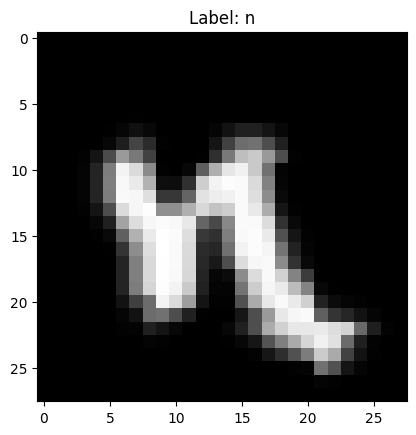

In [91]:
sampleX, sampley = next(iter(train_dataloader))

sampleX.shape, sampley.shape

image = sampleX[0].squeeze() #.permute(-2, -1)

plt.imshow(image, cmap='gray')
plt.title(f'Label: {mapping_dict[sampley[0].item()]}')
plt.show()

In [96]:
models = {
    "SimpleCNN": SimpleCNN().to(device),
    "ResNet": ResNet(ResidualBlock, layers=[1, 1, 1, 1], num_classes=47).to(device),
    "ResNet18": ResNet(ResidualBlock, layers=[2, 2, 2, 2], num_classes=47).to(device),
    "ResNet50": ResNet(ResidualBlock, layers=[3, 4, 6, 3], num_classes=47).to(device)
}

Będziemy przez każdy model przepuszczać po 10 razy dane treningowe.

In [93]:
EPOCHS = 10

Klasyczny model uczenia maszynowego (*k nearest neighbours* – k najbliższych sąsiadów):

In [94]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(train_X, train_y)

val_accuracy = knn.score(test_X, test_y)
print(f"KNN's accuracy: {val_accuracy * 100:.2f}%")

KNN's accuracy: 78.46%


Trenowanie modeli:

In [95]:
results = {}

criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

for model_name, model in models.items():
    print(f"\nTraining {model_name}")
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Initialize lists to store epoch-wise accuracies
    train_accuracies = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train - {model_name}]", leave=False)

        for inputs, labels in train_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)

        train_epoch_loss = train_loss / len(train_dataloader)
        train_epoch_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_epoch_accuracy)  # Save train accuracy

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_progress_bar = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val - {model_name}]", leave=False)

        with torch.no_grad():
            for inputs, labels in val_progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast("cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                val_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)

        val_epoch_loss = val_loss / len(test_dataloader)
        val_epoch_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_epoch_accuracy)  # Save validation accuracy

        print(f"{model_name} - Epoch {epoch+1}/{EPOCHS}, "
              f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")

        scheduler.step(val_epoch_loss)

        if val_epoch_accuracy >= 90:
            break

    results[model_name] = {
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    print(f"Finished Training {model_name}")

c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



Training SimpleCNN


Epoch 1/10 [Train - SimpleCNN]:   0%|          | 0/221 [00:00<?, ?it/s]

c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


SimpleCNN - Epoch 1/10, Train Loss: 2.1275, Train Accuracy: 49.46%, Val Loss: 2.2847, Val Accuracy: 34.65%


SimpleCNN - Epoch 2/10, Train Loss: 0.8915, Train Accuracy: 76.65%, Val Loss: 0.9298, Val Accuracy: 73.55%


SimpleCNN - Epoch 3/10, Train Loss: 0.6611, Train Accuracy: 80.94%, Val Loss: 0.7657, Val Accuracy: 76.37%


SimpleCNN - Epoch 4/10, Train Loss: 0.5675, Train Accuracy: 82.74%, Val Loss: 0.6091, Val Accuracy: 81.49%


SimpleCNN - Epoch 5/10, Train Loss: 0.5193, Train Accuracy: 83.91%, Val Loss: 0.5853, Val Accuracy: 81.91%


SimpleCNN - Epoch 6/10, Train Loss: 0.4900, Train Accuracy: 84.46%, Val Loss: 0.5588, Val Accuracy: 82.66%


SimpleCNN - Epoch 7/10, Train Loss: 0.4714, Train Accuracy: 84.74%, Val Loss: 0.7065, Val Accuracy: 77.07%


SimpleCNN - Epoch 8/10, Train Loss: 0.4535, Train Accuracy: 85.34%, Val Loss: 0.5331, Val Accuracy: 83.08%


SimpleCNN - Epoch 9/10, Train Loss: 0.4432, Train Accuracy: 85.50%, Val Loss: 0.5603, Val Accuracy: 81.77%


SimpleCNN - Epoch 10/10, Train Loss: 0.4341, Train Accuracy: 85.77%, Val Loss: 0.5250, Val Accuracy: 83.17%
Finished Training SimpleCNN

Training ResNet


ResNet - Epoch 1/10, Train Loss: 0.6644, Train Accuracy: 78.20%, Val Loss: 0.5313, Val Accuracy: 81.73%


ResNet - Epoch 2/10, Train Loss: 0.4120, Train Accuracy: 85.19%, Val Loss: 0.4402, Val Accuracy: 84.26%


ResNet - Epoch 3/10, Train Loss: 0.3710, Train Accuracy: 86.35%, Val Loss: 0.4338, Val Accuracy: 84.71%


ResNet - Epoch 4/10, Train Loss: 0.3507, Train Accuracy: 86.98%, Val Loss: 0.4007, Val Accuracy: 85.81%


ResNet - Epoch 5/10, Train Loss: 0.3376, Train Accuracy: 87.42%, Val Loss: 0.3924, Val Accuracy: 85.65%


ResNet - Epoch 6/10, Train Loss: 0.3264, Train Accuracy: 87.73%, Val Loss: 0.3691, Val Accuracy: 86.47%


ResNet - Epoch 7/10, Train Loss: 0.3147, Train Accuracy: 88.13%, Val Loss: 0.3688, Val Accuracy: 86.97%


ResNet - Epoch 8/10, Train Loss: 0.3121, Train Accuracy: 88.20%, Val Loss: 0.3530, Val Accuracy: 87.10%


ResNet - Epoch 9/10, Train Loss: 0.3043, Train Accuracy: 88.41%, Val Loss: 0.3686, Val Accuracy: 86.73%


ResNet - Epoch 10/10, Train Loss: 0.3037, Train Accuracy: 88.47%, Val Loss: 0.3561, Val Accuracy: 86.81%
Finished Training ResNet

Training ResNet18


ResNet18 - Epoch 1/10, Train Loss: 0.7128, Train Accuracy: 76.54%, Val Loss: 0.6422, Val Accuracy: 78.32%


ResNet18 - Epoch 2/10, Train Loss: 0.4230, Train Accuracy: 84.73%, Val Loss: 0.4393, Val Accuracy: 84.44%


ResNet18 - Epoch 3/10, Train Loss: 0.3846, Train Accuracy: 85.99%, Val Loss: 0.4292, Val Accuracy: 84.45%


ResNet18 - Epoch 4/10, Train Loss: 0.3597, Train Accuracy: 86.65%, Val Loss: 0.4228, Val Accuracy: 85.08%


ResNet18 - Epoch 5/10, Train Loss: 0.3444, Train Accuracy: 87.21%, Val Loss: 0.3838, Val Accuracy: 86.19%


ResNet18 - Epoch 6/10, Train Loss: 0.3294, Train Accuracy: 87.63%, Val Loss: 0.3602, Val Accuracy: 86.99%


ResNet18 - Epoch 7/10, Train Loss: 0.3248, Train Accuracy: 87.80%, Val Loss: 0.3785, Val Accuracy: 86.31%


ResNet18 - Epoch 8/10, Train Loss: 0.3119, Train Accuracy: 88.23%, Val Loss: 0.3550, Val Accuracy: 87.27%


ResNet18 - Epoch 9/10, Train Loss: 0.3084, Train Accuracy: 88.38%, Val Loss: 0.3533, Val Accuracy: 87.38%


ResNet18 - Epoch 10/10, Train Loss: 0.3063, Train Accuracy: 88.42%, Val Loss: 0.3586, Val Accuracy: 87.05%
Finished Training ResNet18

Training ResNet50


ResNet50 - Epoch 1/10, Train Loss: 0.8099, Train Accuracy: 73.82%, Val Loss: 0.8834, Val Accuracy: 71.13%


ResNet50 - Epoch 2/10, Train Loss: 0.4539, Train Accuracy: 83.71%, Val Loss: 0.5344, Val Accuracy: 81.33%


ResNet50 - Epoch 3/10, Train Loss: 0.3948, Train Accuracy: 85.69%, Val Loss: 0.5807, Val Accuracy: 80.44%


ResNet50 - Epoch 4/10, Train Loss: 0.3716, Train Accuracy: 86.30%, Val Loss: 0.4835, Val Accuracy: 83.24%


ResNet50 - Epoch 5/10, Train Loss: 0.3531, Train Accuracy: 86.85%, Val Loss: 0.4018, Val Accuracy: 85.64%


ResNet50 - Epoch 6/10, Train Loss: 0.3426, Train Accuracy: 87.29%, Val Loss: 0.4238, Val Accuracy: 85.40%


ResNet50 - Epoch 7/10, Train Loss: 0.3324, Train Accuracy: 87.65%, Val Loss: 0.3975, Val Accuracy: 85.95%


ResNet50 - Epoch 8/10, Train Loss: 0.3243, Train Accuracy: 87.81%, Val Loss: 0.4194, Val Accuracy: 85.24%


ResNet50 - Epoch 9/10, Train Loss: 0.3147, Train Accuracy: 88.16%, Val Loss: 0.3675, Val Accuracy: 86.73%


ResNet50 - Epoch 10/10, Train Loss: 0.3102, Train Accuracy: 88.28%, Val Loss: 0.3655, Val Accuracy: 86.66%
Finished Training ResNet50

Training ResNet100


ResNet100 - Epoch 1/10, Train Loss: 1.1500, Train Accuracy: 64.99%, Val Loss: 7.9385, Val Accuracy: 12.12%


KeyboardInterrupt: 

Teraz przetestujemy wyniki trenowania obu sieci na zbiorze danych testowych.

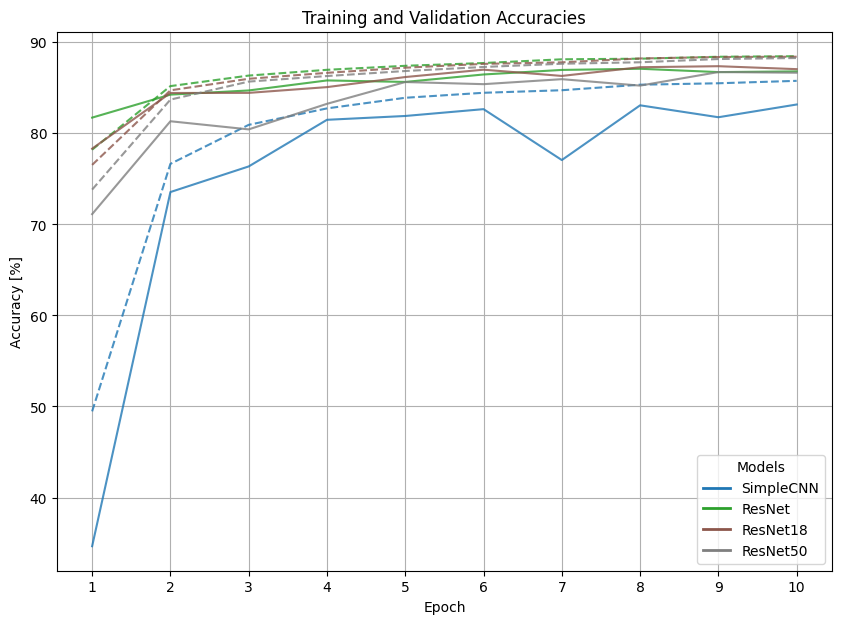

In [97]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.tab10

plt.figure(figsize=(10, 7))

legend_handles = []

for idx, (model_name, metrics) in enumerate(results.items()):
    base_color = colors(idx / len(results))
    epochs = range(1, len(metrics["train_accuracies"]) + 1)

    plt.plot(epochs, metrics["train_accuracies"], color=base_color, linestyle="--", alpha=0.8)
    plt.plot(epochs, metrics["val_accuracies"], color=base_color, linestyle="-", alpha=0.8)

    legend_handles.append(plt.Line2D([0], [0], color=base_color, lw=2, label=model_name))

plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.title("Training and Validation Accuracies")
plt.xticks(range(1, EPOCHS + 1))
plt.legend(handles=legend_handles, title="Models")
plt.grid(True)
plt.show()


Na powyższym wykresie można zaobserwować zmianę poziomu dokładności modelu (*accuracy*), w zależności od numeru treningu (*epoch*). Linie ciągłe reprezentują dokładność uzyskaną na danych testowych, natomiast linie przerywane przedstawiają dokładność na danych treningowych.

<h2>Wnioski</h2>

Sieć resztkowa (oparta na sieci neuronowej splotowej) jest lepszym wyborem do trenowania modelu rozpoznawania znaków. Umożliwia skuteczniejsze dobieranie wag w każdej epoce, co przekłada się na lepszą jakość uczenia. Ssieć resztkowa ma większą szybkość działania w porównaniu do tradycyjnych sieci splotowych.








<h2>Serializacja modeli</h2>

Serializujemy wyniki treningów obu modeli. Wytrenowane, można wykorzystać w aplikacji app.py.

In [98]:
for model_name, model in models.items():
    torch.save(model.state_dict(), f'models/model_{model_name}.pth')